## 0  Загрузка необходимых библиотек и данных

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('weatherAUS.csv')
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73982,2012-06-16,Portland,8.5,14.1,2.4,2.2,3.3,W,65.0,NNW,WNW,20.0,22.0,92.0,92.0,1009.1,1010.1,7.0,8.0,10.1,12.0,Yes,14.6,Yes
73983,2012-06-17,Portland,9.8,14.7,14.6,1.4,7.6,WSW,46.0,WSW,W,24.0,20.0,68.0,91.0,1019.1,1020.8,NaN,7.0,12.2,12.4,Yes,5.4,Yes
73984,2012-06-18,Portland,8.2,15.0,5.4,0.6,4.1,WSW,57.0,NNW,WNW,17.0,28.0,96.0,88.0,1022.2,1019.2,7.0,7.0,10.3,14.6,Yes,4.4,Yes
73985,2012-06-19,Portland,4.9,13.2,4.4,1.0,8.4,NNE,43.0,SSE,N,2.0,13.0,76.0,51.0,1025.6,1022.8,3.0,5.0,8.0,12.1,Yes,0.0,No


## 1 Осмотр данных

In [ ]:
df.isnull().sum()

Date                 0
Location             0
MinTemp            437
MaxTemp            213
Rainfall           903
Evaporation      37679
Sunshine         44217
WindGustDir       5503
WindGustSpeed     5496
WindDir9am        6564
WindDir3pm        2517
WindSpeed9am      1116
WindSpeed3pm      1722
Humidity9am       1100
Humidity3pm       1523
Pressure9am       9698
Pressure3pm       9647
Cloud9am         28569
Cloud3pm         29527
Temp9am            772
Temp3pm           1247
RainToday          904
RISK_MM              1
RainTomorrow         1
dtype: int64

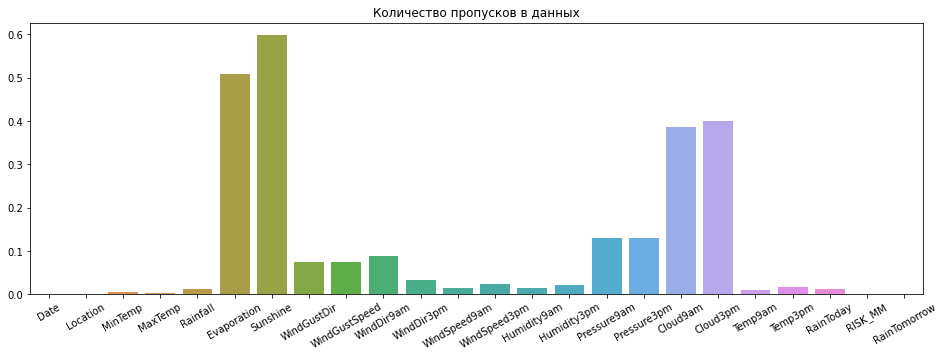

In [ ]:
plt.figure(figsize = (16, 5))
sns.barplot(x = df.isnull().sum().index, y = df.isnull().sum().values/len(df.index))
plt.xticks(rotation = 30)
plt.title('Количество пропусков в данных')
plt.show()

In [ ]:
num_features = df.select_dtypes(exclude = 'O').columns
cat_features = df.select_dtypes(include = 'O').columns[1:]
df.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RISK_MM          float64
RainTomorrow      object
dtype: object

### 1.1 Категориальные данные

In [ ]:
df[cat_features].describe()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,73987,68484,67423,71470,73083,73986
unique,26,16,16,16,2,2
top,Canberra,W,N,S,No,No
freq,3418,5898,6256,5722,57006,57635


Видно, что в категорильных данных относительно немного пропусков, их можно заполнить модой. Все признаки, кроме  *Location*, лучше кодировать с помощью *One-hot-encoding* (для *Location* слишком много значений). 

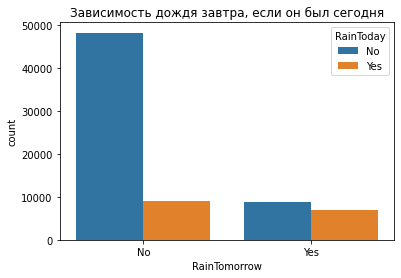

In [ ]:
sns.countplot(df['RainTomorrow'], hue = df['RainToday'])
plt.title('Зависимость дождя завтра, если он был сегодня')
plt.show()

Как видно, существует довольно отчетливая связь между выпадением осадков завтра и сегодня.

In [ ]:
df[df['RainToday'].isnull()].RainTomorrow.value_counts()

No     456
Yes    447
Name: RainTomorrow, dtype: int64

In [ ]:
df['RainToday'].fillna('Yes', inplace = True)

Похоже, что пропуски стоит заполнить значением *Yes*, так как при этом параметре в целевом признаке наблюдается похожее соотношение.

In [ ]:
for col in cat_features:
  print(df[col].value_counts()[:5])

Canberra    3418
Sydney      3337
Bendigo     3034
Ballarat    3028
Albury      3011
Name: Location, dtype: int64
W      5898
S      5483
N      5059
WSW    4845
WNW    4794
Name: WindGustDir, dtype: int64
N      6256
W      5456
SW     5035
NW     4863
WNW    4638
Name: WindDir9am, dtype: int64
S      5722
W      5558
SE     5156
NE     5018
WNW    4949
Name: WindDir3pm, dtype: int64
No     57006
Yes    16981
Name: RainToday, dtype: int64
No     57635
Yes    16351
Name: RainTomorrow, dtype: int64


Пропуски в этих признаках заполним модой, распределение в них относительно сбалансированно, пропусков относительно немного.

### 1.2 Вещественные признаки

In [ ]:
df[num_features].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,73550.000000,73774.000000,73084.000000,36308.000000,29770.000000,68491.000000,72871.000000,72265.000000,72887.000000,72464.000000,64289.000000,64340.000000,45418.000000,44460.000000,73215.000000,72740.000000,73986.000000
mean,11.245418,22.245973,2.346520,5.207401,7.351864,40.170636,13.878553,18.520072,71.133769,52.160452,1018.260539,1015.894167,4.606147,4.695232,15.786795,20.793748,2.360628
std,6.222195,6.924300,8.276436,4.153535,3.836300,14.381767,9.388087,9.385423,17.872455,20.735892,7.107543,6.979740,2.906908,2.692401,6.044240,6.736408,8.290042
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,1.000000,980.500000,979.000000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,6.800000,17.500000,0.000000,2.400000,4.500000,30.000000,7.000000,11.000000,59.000000,37.000000,1013.600000,1011.200000,1.000000,2.000000,11.500000,16.200000,0.000000
50%,11.400000,21.800000,0.000000,4.200000,8.200000,39.000000,13.000000,17.000000,72.000000,52.000000,1018.400000,1016.000000,6.000000,5.000000,16.000000,20.300000,0.000000
75%,16.100000,26.600000,0.600000,7.000000,10.400000,48.000000,19.000000,24.000000,85.000000,66.000000,1023.000000,1020.600000,7.000000,7.000000,20.300000,25.000000,0.600000
max,31.900000,47.300000,371.000000,145.000000,14.500000,135.000000,130.000000,83.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.700000,46.700000,371.000000


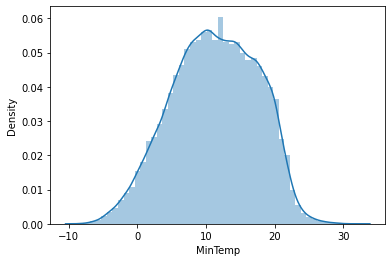

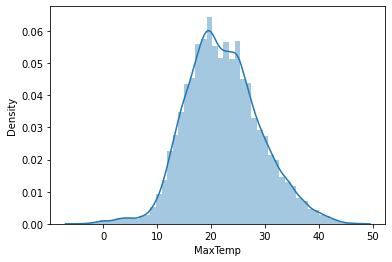

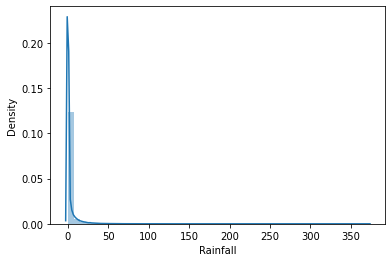

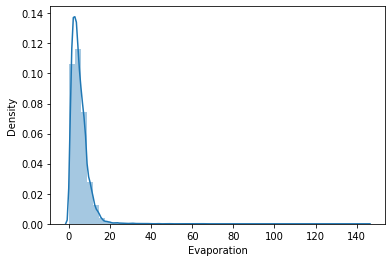

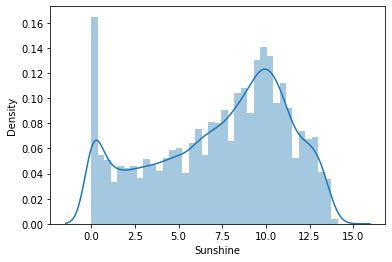

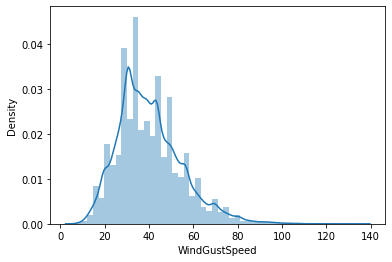

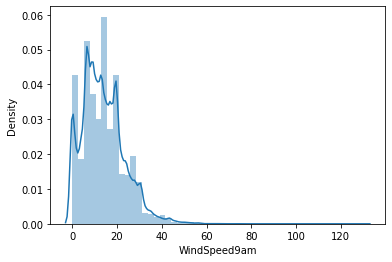

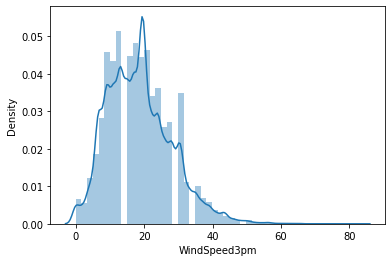

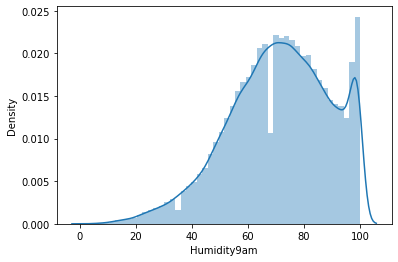

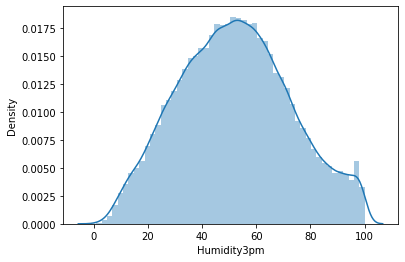

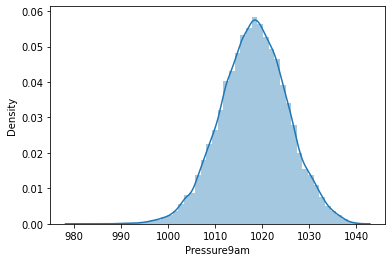

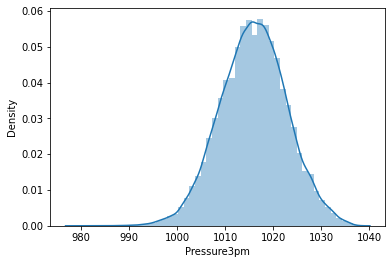

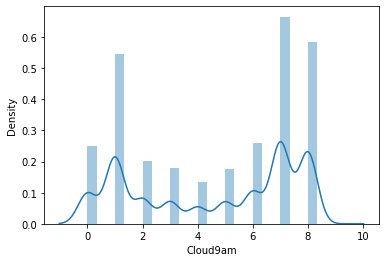

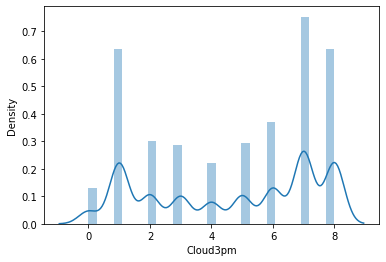

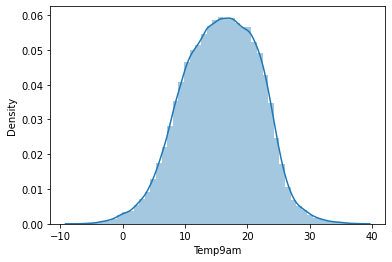

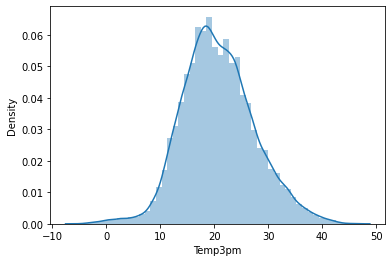

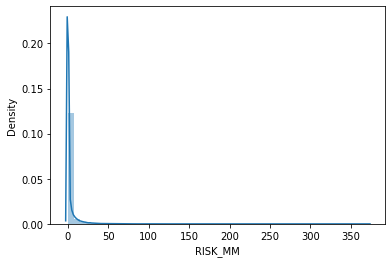

In [ ]:
for col in num_features:
  sns.distplot(df[col])
  plt.show()

Замечания по графикам:
* Признаки 'Clouds' больше похожи на категориальные
* Довольно много признаков имеют нормальное распределение
* Есть несколько признаков, которые возможно нормализовать с помощью логарифмирования(судя по графикам распределений, смещенным к нулю)

Если будет низкое качество у всех алгоритмов, можно попробовать прологарифмировать некоторые признаки, перевести 'clouds' из количественных в категориальные признаки.

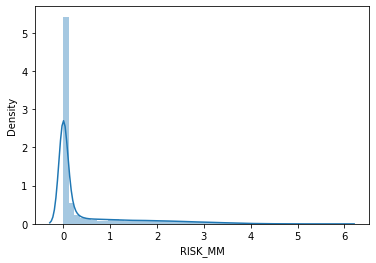

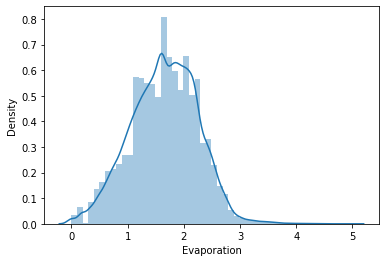

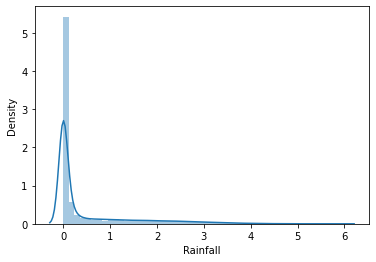

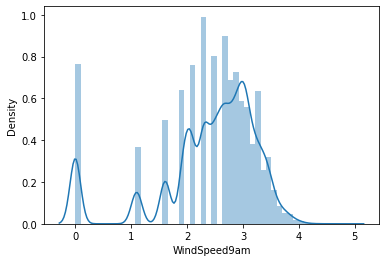

In [ ]:
# графики распределения признакиов при логарифмировании 
for col in ['RISK_MM', 'Evaporation', 'Rainfall', 'WindSpeed9am']:
  sns.distplot(np.log1p(df[col]))
  plt.show()

## 2 Предподготовка признаков

* Заполняем пропуски в категориальных и количественных данных
* Кодируем категоральные данные
* Нормируем количественные данные

In [ ]:
X_ = df.drop(['Date', 'RainTomorrow'], axis = 1)
y_ = df['RainTomorrow'].apply(lambda x: 1 if x == 'Yes' else 0)

In [ ]:
def prepare_dataset(df, num_f, cat_f, for_kmeans = False):
  new_df = df.copy()

  for col in num_f:
    new_df[col] = new_df[col].apply(lambda x: new_df[col].median() if x != x else x)
    new_df[col] = (new_df[col] - new_df[col].mean())/new_df[col].std()
    
  for col in cat_f:
    if col == 'RainToday':
      new_df[col].fillna('Yes', inplace = True)
    else:
      new_df[col].fillna(new_df[col].mode()[0], inplace = True)

  if not for_kmeans:
    encoded = pd.get_dummies(new_df[cat_f], drop_first=True)
    new_df.drop(cat_f, axis=1, inplace=True)
    new_df = new_df.join(encoded)
  
  else:
    encoded = OrdinalEncoder().fit_transform(new_df[cat_f])
    new_df.drop(cat_f, axis=1, inplace=True)
    new_df = new_df.join(encoded)

  return new_df

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', missing_values='miss')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)])


In [ ]:
X_ = prepare_dataset(X_, num_features, cat_features[:-1])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y_.values, test_size = 0.25, 
                                                    shuffle = False)

In [ ]:
X_train.isnull().sum().sum()

0

## 3 Обучение моделей и их результаты

Выбранные метрики: accuracy - для общего числа предсказаний, recall и precision - для выявления слабых сторон моделей, f1 - для контроля качества (наша целевая выборка неравномрерна, соотношение классов ~ 1:4, эта метрика устойчива к таким несбалансированным данным)

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate, StratifiedKFold, \
                                    GridSearchCV
                                    
from sklearn.metrics import accuracy_score, recall_score, \
                            precision_score, f1_score, make_scorer

In [ ]:
def test_fit_cross_model(model, method = 'cv'):
  
  if method == 'cv':
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    '''scoring = {'Accuracy': make_scorer(accuracy_score), 
             'Recall': make_scorer(recall_score),
             'Precision': make_scorer(precision_score),
             'F1': make_scorer(f1_score)}'''

    res_mas = cross_validate(model, X_train, y_train, scoring = scoring, 
                                cv = StratifiedKFold(n_splits = 8), n_jobs = -1)

  else:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    res_mas = {'Accuracy': accuracy_score(y_pred=y_pred, y_true=y_test), 
               'Recall': recall_score(y_pred=y_pred, y_true=y_test),
                'Precision': precision_score(y_pred=y_pred, y_true=y_test),
                'F1':f1_score(y_pred=y_pred, y_true=y_test)}
               
  return res_mas


In [ ]:
log_estim = LogisticRegression()
knc = KNeighborsClassifier(n_jobs = -1)
nbayes = GaussianNB()

### 3.1 Логистическая регрессия

In [ ]:
cv_log = test_fit_cross_model(log_estim)
test_log = test_fit_cross_model(log_estim, method = 'hold_out')

In [ ]:
print('Время обучения при запуске предыдущей ячейки = 9.65сек\n')  
print('Качество на кросс-валидации')

for key in list(cv_log.keys())[2:]:
  print(key[5:], round(cv_log[key].mean(), 5))

print('\nКачество на отложенной выборке')
for key in list(test_log.keys()):
  print(key, round(test_log[key].mean(), 5))

Время обучения при запуске предыдущей ячейки = 9.65сек

Качество на кросс-валидации
accuracy 0.98881
precision 0.97861
recall 0.97314
f1 0.97548

Качество на отложенной выборке
Accuracy 0.99665
Recall 0.9837
Precision 1.0
F1 0.99178


Даже с параметрами по умолчанию модель смогла достигнуть очень высокого качества как на обучении, так и на тесте. Причем по всем метриках.

### 3.2 Метод k-ближайших соседей

In [ ]:
cv_log_knn = test_fit_cross_model(knc)
test_log_knn = test_fit_cross_model(knc, method = 'hold_out')

In [ ]:
print('Время обучения при запуске предыдущей ячейки = 530сек\n')
print('Качество на кросс-валидации')
for key in list(cv_log_knn.keys())[2:]:
  print(key[5:], round(cv_log_knn[key].mean(), 5))

print('\nКачество на отложенной выборке')
for key in list(test_log_knn.keys()):
  print(key, round(test_log_knn[key].mean(), 5))

Время обучения при запуске предыдущей ячейки = 530сек

Качество на кросс-валидации
accuracy 0.83503
precision 0.73205
recall 0.55021
f1 0.61274

Качество на отложенной выборке
Accuracy 0.86106
Recall 0.49829
Precision 0.7411
F1 0.59591


Качество оставляет желать лучшего и на перекрестной проверке, и на тестовой выборке. К тому же обучается эта модель намного дольше, чем модель логистической регрессии. Оптимизация модели может занять очень много времени.

In [ ]:
# оптимизация происходит очень долго, из-за one-hot кодирования
params = {'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']}

grid_search = GridSearchCV(knc, params,
                           cv = StratifiedKFold(n_splits = 8, random_state = 0), 
                           scoring = 'f1', n_jobs = -1)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_

### 3.3 Наивный Байессовский классификатор

In [ ]:
cv_bayes = test_fit_cross_model(nbayes)
test_bayes = test_fit_cross_model(nbayes, method = 'hold_out')

In [ ]:
print('Время обучения при запуске предыдущей ячейки = 2.808сек\n')
print('Качество на кросс-валидации')
for key in list(cv_bayes.keys())[2:]:
  print(key[5:], round(cv_bayes[key].mean(), 5))

print('\nКачество на отложенной выборке')
for key in list(test_bayes.keys()):
  print(key, round(test_bayes[key].mean(), 5))

Время обучения при запуске предыдущей ячейки = 2.808сек

Качество на кросс-валидации
accuracy 0.73168
precision 0.49653
recall 0.88659
f1 0.62229

Качество на отложенной выборке
Accuracy 0.88782
Recall 0.99869
Precision 0.64724
F1 0.78544


Качество тоже значительно хуже лог-регресии, как и у метрического метода. А по времени обучения вышло меньше, чем у логистической регрессии.

## 4 Анализ результатов работы моделей

Для этих данных лучше всего использовать модель логистической регресии, она показала очень высокое качество и на обучении, и на отложенной выборке, время затраченное на обучение довольно мало. Байессовский классификатор имеет качество значительно уступающее модели логистической регресии, однако обучение заняло в 4 раза меньше времени нежели у лог-регрессии. У метода ближайщих соседей очень большое время обучения(из-за кодирования категориальных признаков значительно увеличился размер данных), качество - занчительно не отличается от наивного Байесса. Этот алгоритм не стоит применять к этим данным(даже если рассматривать оптимизацию параметров, то это займет огромное количество времени, к тому же нельзя утверждать, что качество у новой модели будет лучше, чем у лог-регресси, которую даже оптимизировать не нужно для высокого качества).

* Параметры у всех моделей - по умолчанию
* Время обучения и тестирования: логистическая регрессия ~ 9.5 сек; метод к-ближайших соседей ~ 530 сек; Байессовский классификатор ~ 3 сек

Качество моделей (см. таблицы снизу):

In [ ]:
ar_test_mean1 = []#np.zeros((3, 5))
ar_test_mean2 = []
ar_test_mean3 = []

for ar in list(test_log.values()):
  ar_test_mean1.append(round(ar.mean(), 5))

for ar in list(test_log_knn.values()):
  ar_test_mean2.append(round(ar.mean(), 5))  

for ar in list(test_bayes.values()):
  ar_test_mean3.append(round(ar.mean(), 5))  

In [ ]:
ar_cv_mean1 = []
ar_cv_mean2 = []
ar_cv_mean3 = []

for ar in list(cv_log.values())[2:]:
  ar_cv_mean1.append(round(ar.mean(), 5))

for ar in list(cv_log_knn.values())[2:]:
  ar_cv_mean2.append(round(ar.mean(), 5))  

for ar in list(cv_bayes.values())[2:]:
  ar_cv_mean3.append(round(ar.mean(), 5))  

In [ ]:
pd.DataFrame({'Логистическая регрессия': ar_cv_mean1, 
              'Метод K-ближ. соседей': ar_cv_mean2, 
              'Наив. Байессовский классиф.': ar_cv_mean3}, 
             index = ['Accuracy_cv', 'Recall_cv', 'Presicion_cv', 'F1_cv'])

,Логистическая регрессия,Метод K-ближ. соседей,Наив. Байессовский классиф.
Accuracy_cv,0.98881,0.83503,0.73168
Recall_cv,0.97861,0.73205,0.49653
Presicion_cv,0.97314,0.55021,0.88659
F1_cv,0.97548,0.61274,0.62229


In [ ]:
pd.DataFrame({'Логистическая регрессия': ar_test_mean1, 
              'Метод K-ближ. соседей': ar_test_mean2, 
              'Наив. Байессовский классиф.': ar_test_mean3}, 
             index = ['Accuracy_hold_out', 'Recall_hold_out', 'Presicion_hold_out', 'F1_hold_out'])

,Логистическая регрессия,Метод K-ближ. соседей,Наив. Байессовский классиф.
Accuracy_hold_out,0.99665,0.86106,0.88782
Recall_hold_out,0.98370,0.49829,0.99869
Presicion_hold_out,1.00000,0.74110,0.64724
F1_hold_out,0.99178,0.59591,0.78544
